In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
%matplotlib inline


In [3]:
# Reading the dataset
df = pd.read_csv("Data/Superstore_data.csv")
furni_sales = df.loc[df['Category'] == 'Furniture']


# Data Preprocessing

In [4]:
f_sales = furni_sales.groupby('Order Date')['Sales'].sum().reset_index()
f_sales['Order Date'] = pd.to_datetime(f_sales['Order Date'])
f_sales['Sales'] = f_sales['Sales'].astype(int)



print(sklearn.__version__)

f_sales.head(5)

0.19.0


,Order Date,Sales
0,2017-01-01,975
1,2014-01-10,51
2,2015-01-10,1018
3,2016-01-10,104
4,2014-01-11,9


In [5]:
f_sales.set_index('Order Date',inplace = True)
f_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 889 entries, 2017-01-01 to 2017-09-09
Data columns (total 1 columns):
Sales    889 non-null int64
dtypes: int64(1)
memory usage: 13.9 KB


In [6]:
y = f_sales['Sales'].resample('MS').mean()

from sklearn.model_selection import train_test_split
ts_train, ts_test = train_test_split(y,shuffle = False)


## Check Stationarity

In [7]:
from statsmodels.tsa.stattools import adfuller

In [8]:
def test_stationarity(timeseries):
    # Rolling Statistics
#    rolmean = pd.rolling_mean(timeseries, window=12)
#    rolstd = pd.rolling_std(timeseries,window=12)

    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()



    # Plot rolling statistics
    plt.figure(figsize=(15,6))
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(rolmean,color='red',label='Rolling Mean')
    std  = plt.plot(rolstd,color='black',label='Rolling STD')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

Results of Dickey-Fuller Test:
Test Statistic                 -4.297890
p-value                         0.000448
#Lags Used                      0.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


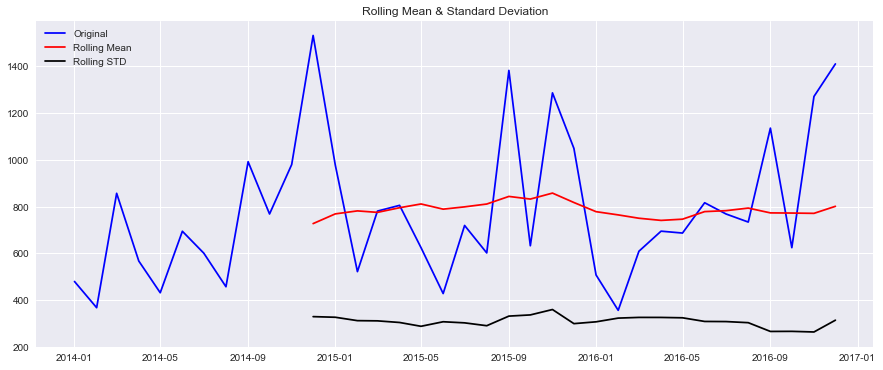

In [9]:
test_stationarity(ts_train)

Results of Dickey-Fuller Test:
Test Statistic                 -4.399725
p-value                         0.000297
#Lags Used                      0.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


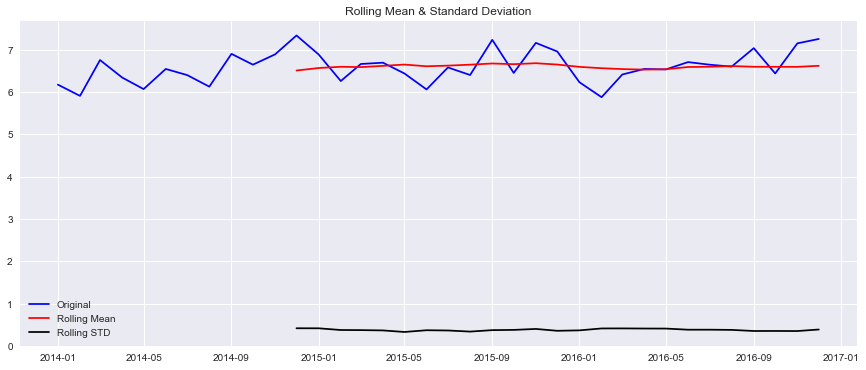

In [10]:
ts_log = np.log(ts_train)
test_stationarity(ts_log)  

# Moving Average

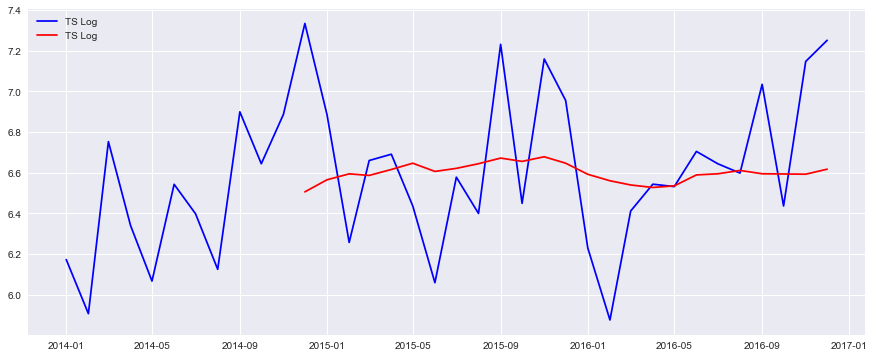

In [11]:
ts_ma = ts_log.rolling(12).mean()
plt.figure(figsize=(15,6))
plt.plot(ts_log,color='blue',label='TS Log')
plt.plot(ts_ma,color='red',label='TS Log')
plt.legend(loc='best')

Results of Dickey-Fuller Test:
Test Statistic                 -4.237626
p-value                         0.000569
#Lags Used                      0.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


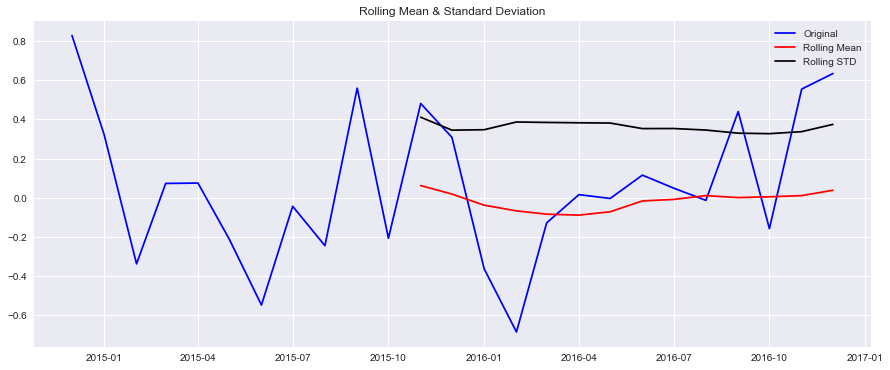

In [12]:
ts_log_moving_avg_diff = ts_log-ts_ma
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                 -3.818530
p-value                         0.002723
#Lags Used                     10.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


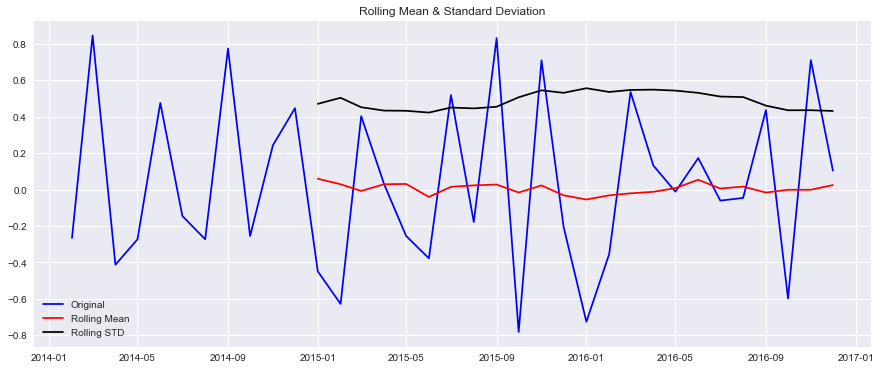

In [13]:
ts_log_shift_diff = ts_log-ts_log.shift()
ts_log_shift_diff.dropna(inplace=True)
test_stationarity(ts_log_shift_diff)

In [14]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [15]:
lag_acf = acf(ts_log_shift_diff, nlags=12)
lag_pacf = pacf(ts_log_shift_diff, nlags=12, method='ols')

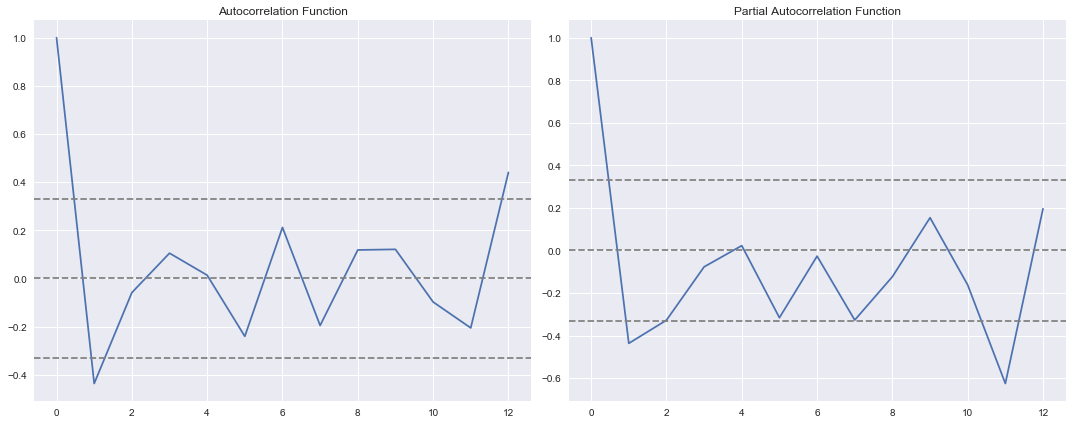

In [16]:
#Plot ACF: 
plt.figure(figsize=(15,6))
plt.subplot(121) 
plt.plot(lag_acf)

plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_shift_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_shift_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_shift_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_shift_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# ARIMA model

0.50293644651892933

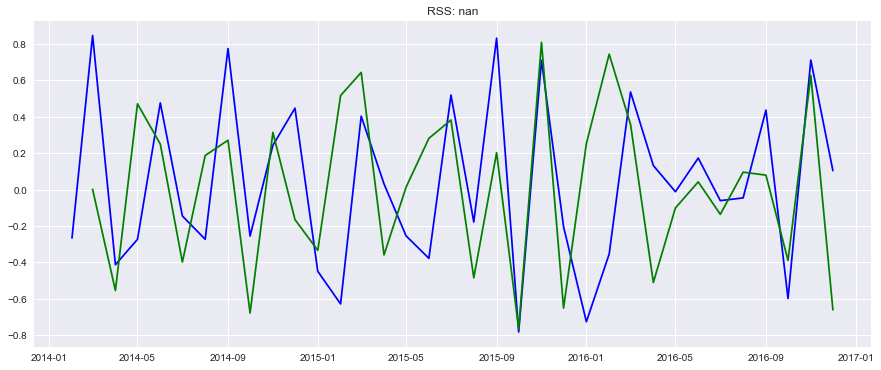

In [22]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log_shift_diff, order=(0, 1, 1))  
results_AR = model.fit(disp=-1)  
plt.figure(figsize=(15,6))
plt.plot(ts_log_shift_diff,color='blue')
plt.plot(results_AR.fittedvalues, color='green')

plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_shift_diff)**2))

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse(results_AR.fittedvalues,ts_log_shift_diff)